Loading data...
Data loaded. Total follow-up records: 43
Preprocessing data...
Preprocessing complete. Processed data shape: (14, 9)
Features used for modeling: ['days_to_follow_up', 'days_to_progression', 'progression_or_recurrence_anatomic_site', 'progression_or_recurrence_type', 'progression_or_recurrence', 'molecular_tests', 'other_clinical_attributes', 'target', 'timepoint_category_Last Contact']
Training and evaluating the model...


<ipython-input-2-d31fce5b0f35>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["disease_response"].apply(label_response)
<ipython-input-2-d31fce5b0f35>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["days_to_follow_up"] = pd.to_numeric(df["days_to_follow_up"], errors="coerce")
<ipython-input-2-d31fce5b0f35>:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Thi

Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

Confusion Matrix:
 [[0 1]
 [0 4]]
ROC AUC Score: 0.75


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


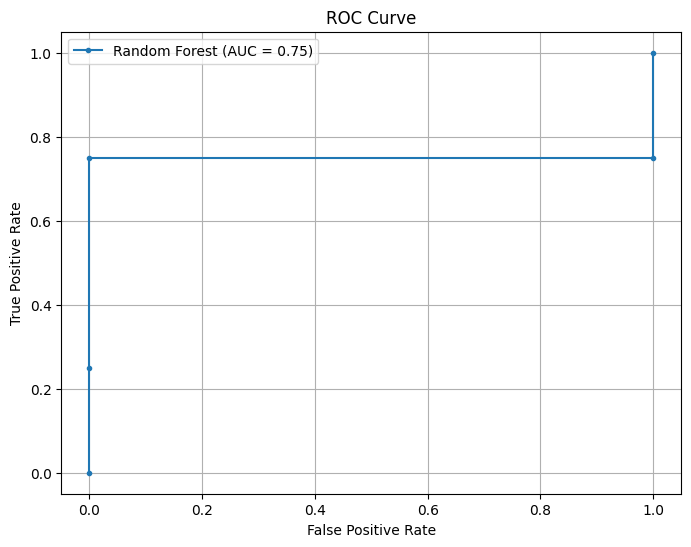

Script complete.


In [2]:
#!/usr/bin/env python3
"""
A complete script to load the clinical dataset,
preprocess the data, build a machine learning model
to predict immune response (using disease_response as a proxy),
and evaluate the results.
"""

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)

def load_data(filepath):
    """
    Load the clinical JSON file and flatten the nested follow-up records.
    Each follow-up record is treated as one sample.
    """
    with open(filepath, 'r') as f:
        data = json.load(f)

    # Each record in the JSON represents a case; extract its follow-up records
    rows = []
    for case in data:
        case_id = case.get("case_id", None)
        if "follow_ups" in case:
            for fu in case["follow_ups"]:
                fu["case_id"] = case_id
                rows.append(fu)
    df = pd.DataFrame(rows)
    return df

def preprocess_data(df):
    """
    Preprocess the data by:
      - Dropping rows missing a disease_response.
      - Creating a binary target from disease_response:
          -- "Tumor Free" is labeled as 1 (good outcome), otherwise 0.
      - Converting days_to_follow_up to numeric and filling missing values.
      - One-hot encoding categorical features (if present).
      - Dropping unneeded columns.
    """
    # Ensure that 'disease_response' exists
    if "disease_response" not in df.columns:
        raise ValueError("The dataframe does not contain a 'disease_response' column.")

    # Drop rows missing target information
    df = df.dropna(subset=["disease_response"])

    # Define the label function
    def label_response(x):
        if "Tumor Free" in x:
            return 1
        else:
            return 0

    # Create the binary target
    df["target"] = df["disease_response"].apply(label_response)

    # Convert days_to_follow_up to numeric and fill missing values with median
    if "days_to_follow_up" in df.columns:
        df["days_to_follow_up"] = pd.to_numeric(df["days_to_follow_up"], errors="coerce")
        df["days_to_follow_up"].fillna(df["days_to_follow_up"].median(), inplace=True)
    else:
        df["days_to_follow_up"] = 0

    # One-hot encode the timepoint_category if it exists
    if "timepoint_category" in df.columns:
        df = pd.get_dummies(df, columns=["timepoint_category"], drop_first=True)

    # Drop columns that are not needed for modeling
    cols_to_drop = ["disease_response", "follow_up_id", "created_datetime",
                    "updated_datetime", "case_id", "submitter_id", "state"]
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

    return df

def train_and_evaluate(df):
    """
    Split the dataset, train a Random Forest classifier,
    and evaluate the model using accuracy, classification report,
    confusion matrix, and ROC-AUC.
    """
    # Separate features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Split the data (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Train a Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # ROC Curve and AUC for binary classification
    if len(np.unique(y)) == 2:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        print("ROC AUC Score:", auc)

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, marker='.', label=f'Random Forest (AUC = {auc:.2f})')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model

def main():
    # Set the path to your clinical dataset
    filepath = "clinical.cart.2025-02-19.json"

    # Load the data
    print("Loading data...")
    df = load_data(filepath)
    print(f"Data loaded. Total follow-up records: {df.shape[0]}")

    # Preprocess the data
    print("Preprocessing data...")
    df_processed = preprocess_data(df)
    print("Preprocessing complete. Processed data shape:", df_processed.shape)
    print("Features used for modeling:", df_processed.columns.tolist())

    # Train and evaluate the model
    print("Training and evaluating the model...")
    train_and_evaluate(df_processed)
    print("Script complete.")

if __name__ == "__main__":
    main()


In [4]:
import json
import pandas as pd

def load_and_flatten_json(filepath):
    """
    Loads a JSON file and flattens nested follow-up records.

    For each case in the JSON, if 'follow_ups' is present, the function:
      - Retrieves the case's ID.
      - Iterates through each follow-up record.
      - Adds the case_id to the follow-up record.
      - Appends the follow-up record to a list.

    Returns:
        A Pandas DataFrame where each row represents a follow-up record.
    """
    # Open and load the JSON data from the given file path
    with open(filepath, 'r') as f:
        data = json.load(f)

    # Initialize an empty list to store flattened follow-up records
    rows = []

    # Iterate over each case in the JSON data
    for case in data:
        # Get the case id (or None if not present)
        case_id = case.get("case_id", None)
        # Check if the case contains follow-up records
        if "follow_ups" in case:
            # Iterate over each follow-up record in the case
            for fu in case["follow_ups"]:
                # Add the case_id into the follow-up record
                fu["case_id"] = case_id
                # Append the modified follow-up record to the rows list
                rows.append(fu)

    # Convert the list of dictionaries into a Pandas DataFrame
    df = pd.DataFrame(rows)

    return df

# Example usage:
if __name__ == "__main__":
    filepath = "clinical.cart.2025-02-19.json"  # Adjust your file path as needed
    df_flat = load_and_flatten_json(filepath)
    print("Flattened DataFrame:")
    print(df_flat.head())


Flattened DataFrame:
       timepoint_category                          follow_up_id  \
0               Follow-up  1305707d-5ed6-4331-82ba-558dacfde5f7   
1  Post Initial Treatment  2b71a34e-d277-4264-a945-a5957c07597a   
2               Follow-up  e3661793-65e0-4815-9744-ce386c1fc7fd   
3            Last Contact  e6851be1-2d78-45ed-b152-f65f26aba524   
4               Follow-up  fcaba886-f05a-47b7-8255-89d5c60a1587   

                   updated_datetime             submitter_id disease_response  \
0  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up4    WT-With Tumor   
1  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up5              NaN   
2  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up2    TF-Tumor Free   
3  2025-01-08T12:58:05.350809-06:00   TCGA-A7-A13E_follow_up    WT-With Tumor   
4  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up3    TF-Tumor Free   

   days_to_follow_up     state                  created_datetime  \
0              614.0 

In [5]:
import json
import pandas as pd

def load_and_flatten_json(filepath, drop_missing_response=True):
    """
    Loads a JSON file and flattens nested follow-up records.

    Each case in the JSON is processed to extract its follow-up records.
    The case_id is added to each follow-up record.

    Parameters:
        filepath (str): Path to the JSON file.
        drop_missing_response (bool): If True, rows with missing "disease_response" are dropped.

    Returns:
        pd.DataFrame: Flattened DataFrame with follow-up records.
    """
    # Open and load the JSON data
    with open(filepath, 'r') as f:
        data = json.load(f)

    rows = []
    for case in data:
        case_id = case.get("case_id", None)
        if "follow_ups" in case:
            for fu in case["follow_ups"]:
                # Add the case_id into each follow-up record
                fu["case_id"] = case_id
                rows.append(fu)

    # Create DataFrame from the flattened rows
    df = pd.DataFrame(rows)

    # Optionally drop rows where 'disease_response' is missing
    if drop_missing_response and "disease_response" in df.columns:
        df = df.dropna(subset=["disease_response"])

    return df

# Example usage:
if __name__ == "__main__":
    filepath = "clinical.cart.2025-02-19.json"  # Change as needed
    df_flat = load_and_flatten_json(filepath)
    print("Flattened DataFrame:")
    print(df_flat.head())


Flattened DataFrame:
   timepoint_category                          follow_up_id  \
0           Follow-up  1305707d-5ed6-4331-82ba-558dacfde5f7   
2           Follow-up  e3661793-65e0-4815-9744-ce386c1fc7fd   
3        Last Contact  e6851be1-2d78-45ed-b152-f65f26aba524   
4           Follow-up  fcaba886-f05a-47b7-8255-89d5c60a1587   
16       Last Contact  3310b502-6714-4fa0-8a1b-3d65999f7dba   

                    updated_datetime             submitter_id  \
0   2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up4   
2   2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up2   
3   2025-01-08T12:58:05.350809-06:00   TCGA-A7-A13E_follow_up   
4   2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up3   
16  2025-01-08T12:58:05.350809-06:00   TCGA-A7-A26I_follow_up   

   disease_response  days_to_follow_up     state  \
0     WT-With Tumor              614.0  released   
2     TF-Tumor Free              287.0  released   
3     WT-With Tumor              614.0  released   
4

In [6]:
import json
import pandas as pd

def load_and_flatten_json(filepath, drop_missing_response=True):
    """
    Loads a JSON file and flattens nested follow-up records.

    Each case in the JSON is processed to extract its follow-up records.
    The case_id is added to each follow-up record.

    Parameters:
        filepath (str): Path to the JSON file.
        drop_missing_response (bool): If True, rows with missing "disease_response" are dropped.

    Returns:
        pd.DataFrame: Flattened DataFrame with follow-up records, reindexed.
    """
    with open(filepath, 'r') as f:
        data = json.load(f)

    rows = []
    for case in data:
        case_id = case.get("case_id", None)
        if "follow_ups" in case:
            for fu in case["follow_ups"]:
                # Add the case_id into each follow-up record
                fu["case_id"] = case_id
                rows.append(fu)

    df = pd.DataFrame(rows)

    if drop_missing_response and "disease_response" in df.columns:
        df = df.dropna(subset=["disease_response"])

    # Reset index to have sequential numbering
    df = df.reset_index(drop=True)

    return df

# Example usage:
if __name__ == "__main__":
    filepath = "clinical.cart.2025-02-19.json"  # Adjust as needed
    df_flat = load_and_flatten_json(filepath)
    print("Flattened DataFrame:")
    print(df_flat.head())


Flattened DataFrame:
  timepoint_category                          follow_up_id  \
0          Follow-up  1305707d-5ed6-4331-82ba-558dacfde5f7   
1          Follow-up  e3661793-65e0-4815-9744-ce386c1fc7fd   
2       Last Contact  e6851be1-2d78-45ed-b152-f65f26aba524   
3          Follow-up  fcaba886-f05a-47b7-8255-89d5c60a1587   
4       Last Contact  3310b502-6714-4fa0-8a1b-3d65999f7dba   

                   updated_datetime             submitter_id disease_response  \
0  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up4    WT-With Tumor   
1  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up2    TF-Tumor Free   
2  2025-01-08T12:58:05.350809-06:00   TCGA-A7-A13E_follow_up    WT-With Tumor   
3  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up3    TF-Tumor Free   
4  2025-01-08T12:58:05.350809-06:00   TCGA-A7-A26I_follow_up    TF-Tumor Free   

   days_to_follow_up     state                  created_datetime  \
0              614.0  released  2025-01-06T07:44:11

In [8]:
import json
import pandas as pd
import numpy as np

def load_and_flatten_json(filepath, drop_missing_response=True):
    """
    Loads a JSON file and flattens nested follow-up records.

    Parameters:
        filepath (str): Path to the JSON file.
        drop_missing_response (bool): If True, rows with missing "disease_response" are dropped.

    Returns:
        pd.DataFrame: Flattened DataFrame with follow-up records, cleaned.
    """
    with open(filepath, 'r') as f:
        data = json.load(f)

    rows = []
    for case in data:
        case_id = case.get("case_id", None)
        if "follow_ups" in case:
            for fu in case["follow_ups"]:
                fu["case_id"] = case_id
                rows.append(fu)

    # Convert list to DataFrame
    df = pd.DataFrame(rows)

    # Drop rows where "disease_response" is missing (optional)
    if drop_missing_response and "disease_response" in df.columns:
        df = df.dropna(subset=["disease_response"])

    # Reset index for better readability
    df = df.reset_index(drop=True)

    return df

# ✅ Load the dataset first
filepath = "clinical.cart.2025-02-19.json"  # Update with your actual file path
df = load_and_flatten_json(filepath)

# ✅ NOW Apply cleaning methods
# Drop completely empty columns
df = df.dropna(axis=1, how='all')

# Fill missing values for string/object columns with empty strings
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('')

# Fill missing values for numeric columns with 0
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(0)

# ✅ Display the cleaned DataFrame
print("Cleaned Flattened DataFrame:")
print(df.head())


Cleaned Flattened DataFrame:
  timepoint_category                          follow_up_id  \
0          Follow-up  1305707d-5ed6-4331-82ba-558dacfde5f7   
1          Follow-up  e3661793-65e0-4815-9744-ce386c1fc7fd   
2       Last Contact  e6851be1-2d78-45ed-b152-f65f26aba524   
3          Follow-up  fcaba886-f05a-47b7-8255-89d5c60a1587   
4       Last Contact  3310b502-6714-4fa0-8a1b-3d65999f7dba   

                   updated_datetime             submitter_id disease_response  \
0  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up4    WT-With Tumor   
1  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up2    TF-Tumor Free   
2  2025-01-08T12:58:05.350809-06:00   TCGA-A7-A13E_follow_up    WT-With Tumor   
3  2025-01-08T12:58:05.350809-06:00  TCGA-A7-A13E_follow_up3    TF-Tumor Free   
4  2025-01-08T12:58:05.350809-06:00   TCGA-A7-A26I_follow_up    TF-Tumor Free   

   days_to_follow_up     state                  created_datetime  \
0              614.0  released  2025-01-06T

In [10]:
df["days_to_follow_up"] = df["days_to_follow_up"].fillna(df["days_to_follow_up"].median())


Loading and preprocessing data...
Data ready for ML. Shape: (14, 9)
Training and evaluating the model...
Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

Confusion Matrix:
 [[0 1]
 [0 4]]
ROC AUC Score: 0.75


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


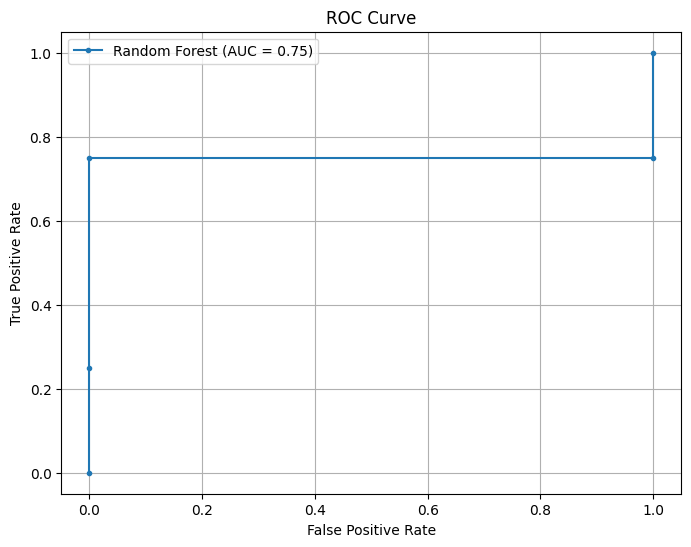

Script complete.


In [11]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

def load_and_preprocess_data(filepath):
    """
    Loads, flattens, and preprocesses the clinical dataset for ML training.
    """
    with open(filepath, 'r') as f:
        data = json.load(f)

    rows = []
    for case in data:
        case_id = case.get("case_id", None)
        if "follow_ups" in case:
            for fu in case["follow_ups"]:
                fu["case_id"] = case_id  # Add case ID to each follow-up
                rows.append(fu)

    df = pd.DataFrame(rows)

    # Drop rows where "disease_response" is missing
    df = df.dropna(subset=["disease_response"])

    # Convert disease_response to a binary variable
    df["target"] = df["disease_response"].apply(lambda x: 1 if "Tumor Free" in x else 0)

    # Convert "days_to_follow_up" to numeric, filling missing with median
    df["days_to_follow_up"] = pd.to_numeric(df["days_to_follow_up"], errors="coerce")
    df["days_to_follow_up"] = df["days_to_follow_up"].fillna(df["days_to_follow_up"].median())

    # Drop non-numeric columns that are not useful
    cols_to_drop = [
        "disease_response", "follow_up_id", "submitter_id", "updated_datetime",
        "created_datetime", "case_id", "state"  # Drop 'state' since it's categorical
    ]
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

    # One-hot encode categorical features
    if "timepoint_category" in df.columns:
        df = pd.get_dummies(df, columns=["timepoint_category"], drop_first=True)

    return df

def train_and_evaluate(df):
    """
    Trains and evaluates a Random Forest classifier on the dataset.
    """
    # Split features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Train-test split (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Plot ROC Curve
    if len(np.unique(y)) == 2:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        print("ROC AUC Score:", auc)

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, marker='.', label=f'Random Forest (AUC = {auc:.2f})')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model

# Main execution
if __name__ == "__main__":
    filepath = "clinical.cart.2025-02-19.json"  # Change as needed
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data(filepath)
    print("Data ready for ML. Shape:", df.shape)

    print("Training and evaluating the model...")
    train_and_evaluate(df)
    print("Script complete.")


In [13]:
# Modify Random Forest with class weights
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")


In [16]:
from sklearn.impute import SimpleImputer  # Import imputer
from imblearn.over_sampling import SMOTE  # Import SMOTE for balancing

def train_and_evaluate(df):
    """
    Trains and evaluates a Random Forest classifier on the dataset.
    """
    # Split features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Train-test split (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # ✅ Step 1: Check for missing values
    print("\nMissing values before imputation:\n", X_train.isnull().sum())

    # ✅ Step 2: Impute missing values using the median for numerical columns
    imputer = SimpleImputer(strategy="median")
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    # ✅ Step 3: Apply SMOTE to balance classes
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Plot ROC Curve
    if len(np.unique(y)) == 2:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        print("ROC AUC Score:", auc)

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, marker='.', label=f'Random Forest (AUC = {auc:.2f})')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model



In [22]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Check for missing values before imputation
print("\nMissing values before imputation:\n", df.isna().sum())

# Drop columns with all missing values
columns_to_drop = df.columns[df.isna().all()].tolist()
if columns_to_drop:
    print(f"\nDropping columns with all missing values: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop)

# Separate columns into numerical and categorical
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Handle numerical columns
if len(numerical_columns) > 0:
    numerical_imputer = SimpleImputer(strategy='median')  # Use 'mean' or 'median'
    df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

# Handle categorical columns only if there are any
if len(categorical_columns) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Check for missing values after imputation
print("\nMissing values after imputation:\n", df.isna().sum())

# Verify the shape before and after imputation
print("\nData Shape After Imputation:", df.shape)

# Ensure 'target' column is in the dataset
if 'target' not in df.columns:
    raise ValueError("Target column 'target' not found in DataFrame. Check column names.")

# Split features and target
X = df.drop(columns=['target'])  # Features
y = df['target']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData split complete!")
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")



Missing values before imputation:
 days_to_follow_up                  0
target                             0
timepoint_category_Last Contact    0
dtype: int64

Missing values after imputation:
 days_to_follow_up                  0
target                             0
timepoint_category_Last Contact    0
dtype: int64

Data Shape After Imputation: (14, 3)

Data split complete!
Training Set Shape: (11, 2), Testing Set Shape: (3, 2)


In [25]:
print(df.columns)


Index(['case_id', 'follow_ups', 'project', 'submitter_id', 'diagnoses',
       'demographic'],
      dtype='object')


In [26]:
df.columns = df.columns.str.strip()


In [27]:
print(df.head())  # View a few rows
print(df.info())  # Check for missing values and column types


                                case_id  \
0  8c7e74e0-71ef-49b8-9217-94b8ef740ef9   
1  b2ecbc0f-2c30-4200-8d5e-7b95424bcadb   
2  f130f376-5801-40f9-975d-a7e2f7b5670d   
3  f2622cdb-ac92-42b3-a1ca-67e133c3dd4a   

                                          follow_ups  \
0  [{'timepoint_category': 'Follow-up', 'follow_u...   
1  [{'timepoint_category': 'Last Contact', 'follo...   
2  [{'timepoint_category': 'Last Contact', 'follo...   
3  [{'timepoint_category': 'Last Contact', 'follo...   

                       project  submitter_id  \
0  {'project_id': 'TCGA-BRCA'}  TCGA-A7-A13E   
1  {'project_id': 'TCGA-BRCA'}  TCGA-A7-A26I   
2  {'project_id': 'TCGA-BRCA'}  TCGA-A7-A0DB   
3  {'project_id': 'TCGA-BRCA'}  TCGA-AC-A3OD   

                                           diagnoses  \
0  [{'morphology': '8500/3', 'submitter_id': 'TCG...   
1  [{'morphology': '8090/3', 'submitter_id': 'TCG...   
2  [{'synchronous_malignancy': 'No', 'ajcc_pathol...   
3  [{'synchronous_malignancy': 'No', '

In [28]:
import json

# Check the first row of 'diagnoses'
print(json.dumps(df['diagnoses'][0], indent=2))


[
  {
    "morphology": "8500/3",
    "submitter_id": "TCGA-A7-A13E_diagnosis2",
    "days_to_diagnosis": 556,
    "created_datetime": "2025-01-06T07:44:11.996213-06:00",
    "treatments": [
      {
        "treatment_anatomic_sites": [
          "Locoregional Site"
        ],
        "updated_datetime": "2025-01-08T12:58:05.350809-06:00",
        "submitter_id": "TCGA-A7-A13E_treatment14",
        "treatment_id": "498d7d01-72f6-4890-abe5-29f015ed9beb",
        "treatment_type": "Surgery, NOS",
        "state": "released",
        "treatment_or_therapy": "no",
        "created_datetime": "2025-01-06T07:44:11.996213-06:00",
        "initial_disease_status": "Recurrent Disease"
      },
      {
        "updated_datetime": "2025-01-08T12:58:05.350809-06:00",
        "submitter_id": "TCGA-A7-A13E_treatment13",
        "treatment_id": "ce10db79-77aa-4c56-bfae-00df7793fcbd",
        "treatment_type": "Radiation Therapy, NOS",
        "state": "released",
        "treatment_or_therapy": "yes"

In [30]:
import pandas as pd
import json

# Load dataset
df = pd.read_json("/content/clinical.cart.2025-02-19.json")

# Extract first diagnosis from the list
df['diagnoses'] = df['diagnoses'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

# Extract relevant features
df['ajcc_t'] = df['diagnoses'].apply(lambda x: x.get('ajcc_pathologic_t', None))
df['ajcc_n'] = df['diagnoses'].apply(lambda x: x.get('ajcc_pathologic_n', None))
df['ajcc_m'] = df['diagnoses'].apply(lambda x: x.get('ajcc_pathologic_m', None))
df['lymph_nodes_positive'] = df['diagnoses'].apply(lambda x: x.get('pathology_details', [{}])[0].get('lymph_nodes_positive', None))

# Define disease response (adjust based on criteria)
df['disease_response'] = df['lymph_nodes_positive'].apply(lambda x: 1 if x == 0 else 0)  # Example: No positive nodes = good response

# Drop original JSON columns
df = df.drop(columns=['diagnoses'])

# Save cleaned dataset
df.to_csv("/content/cleaned_clinical_data.csv", index=False)

print(df.head())


                                case_id  \
0  8c7e74e0-71ef-49b8-9217-94b8ef740ef9   
1  b2ecbc0f-2c30-4200-8d5e-7b95424bcadb   
2  f130f376-5801-40f9-975d-a7e2f7b5670d   
3  f2622cdb-ac92-42b3-a1ca-67e133c3dd4a   

                                          follow_ups  \
0  [{'timepoint_category': 'Follow-up', 'follow_u...   
1  [{'timepoint_category': 'Last Contact', 'follo...   
2  [{'timepoint_category': 'Last Contact', 'follo...   
3  [{'timepoint_category': 'Last Contact', 'follo...   

                       project  submitter_id  \
0  {'project_id': 'TCGA-BRCA'}  TCGA-A7-A13E   
1  {'project_id': 'TCGA-BRCA'}  TCGA-A7-A26I   
2  {'project_id': 'TCGA-BRCA'}  TCGA-A7-A0DB   
3  {'project_id': 'TCGA-BRCA'}  TCGA-AC-A3OD   

                                         demographic ajcc_t   ajcc_n ajcc_m  \
0  {'demographic_id': 'd492d639-2439-50c4-adf8-ea...   None     None   None   
1  {'demographic_id': '6d675722-d247-5cf8-8686-b3...   None     None   None   
2  {'demographic_id': '5f

In [29]:
print(json.dumps(df['follow_ups'][0], indent=2))


[
  {
    "timepoint_category": "Follow-up",
    "follow_up_id": "1305707d-5ed6-4331-82ba-558dacfde5f7",
    "updated_datetime": "2025-01-08T12:58:05.350809-06:00",
    "submitter_id": "TCGA-A7-A13E_follow_up4",
    "disease_response": "WT-With Tumor",
    "days_to_follow_up": 614,
    "state": "released",
    "created_datetime": "2025-01-06T07:44:11.996213-06:00"
  },
  {
    "days_to_progression": 556,
    "timepoint_category": "Post Initial Treatment",
    "follow_up_id": "2b71a34e-d277-4264-a945-a5957c07597a",
    "progression_or_recurrence_anatomic_site": "Lung, NOS",
    "updated_datetime": "2025-01-08T12:58:05.350809-06:00",
    "progression_or_recurrence_type": "Distant",
    "submitter_id": "TCGA-A7-A13E_follow_up5",
    "days_to_follow_up": 556,
    "state": "released",
    "created_datetime": "2025-01-06T07:44:11.996213-06:00",
    "progression_or_recurrence": "Yes"
  },
  {
    "timepoint_category": "Follow-up",
    "follow_up_id": "e3661793-65e0-4815-9744-ce386c1fc7fd",
  

In [35]:
print(df.columns)


Index(['follow_ups', 'project', 'diagnoses', 'demographic',
       'follow_up_timepoint_category', 'follow_up_follow_up', 'project_id',
       'demographic_id'],
      dtype='object')


In [36]:
# Inspect a few rows of the 'diagnoses' and 'demographic' columns
print(df['diagnoses'].head())
print(df['demographic'].head())


0    [{'morphology': '8500/3', 'submitter_id': 'TCG...
1    [{'morphology': '8090/3', 'submitter_id': 'TCG...
2    [{'synchronous_malignancy': 'No', 'ajcc_pathol...
3    [{'synchronous_malignancy': 'No', 'ajcc_pathol...
Name: diagnoses, dtype: object
0    {'demographic_id': 'd492d639-2439-50c4-adf8-ea...
1    {'demographic_id': '6d675722-d247-5cf8-8686-b3...
2    {'demographic_id': '5f43be5d-f1b5-5df5-a708-83...
3    {'demographic_id': '3fe152e8-58a0-5618-94e2-c7...
Name: demographic, dtype: object


In [37]:
# Extract AJCC staging information from 'diagnoses'
df['ajcc_pathologic_stage'] = df['diagnoses'].apply(lambda x: x[0].get('ajcc_pathologic_stage', np.nan) if isinstance(x, list) and len(x) > 0 else np.nan)

# Handle missing values for AJCC staging and other features
df['ajcc_pathologic_stage'] = df['ajcc_pathologic_stage'].fillna('Unknown')

# Check for the relevant information and adjust columns accordingly
print(df[['ajcc_pathologic_stage']].head())


  ajcc_pathologic_stage
0               Unknown
1               Unknown
2             Stage IIA
3             Stage IIB


In [39]:
print(df.columns)


Index(['follow_ups', 'project', 'diagnoses', 'demographic',
       'follow_up_timepoint_category', 'follow_up_follow_up', 'project_id',
       'demographic_id', 'ajcc_stage_encoded'],
      dtype='object')


In [43]:
# Extract 'ajcc_pathologic_stage' safely from 'diagnoses'
def extract_ajcc_stage(diagnoses):
    # Ensure it's a list and has the expected structure
    if isinstance(diagnoses, list) and len(diagnoses) > 0:
        # Extract 'ajcc_pathologic_stage' from the first element, if it exists
        return diagnoses[0].get('ajcc_pathologic_stage', None)
    return None

# Apply the extraction function to the 'diagnoses' column
data['ajcc_stage'] = data['diagnoses'].apply(extract_ajcc_stage)

# Now you can check the results
print(data[['case_id', 'ajcc_stage']].head())


                                case_id ajcc_stage
0  8c7e74e0-71ef-49b8-9217-94b8ef740ef9       None
1  b2ecbc0f-2c30-4200-8d5e-7b95424bcadb       None
2  f130f376-5801-40f9-975d-a7e2f7b5670d  Stage IIA
3  f2622cdb-ac92-42b3-a1ca-67e133c3dd4a  Stage IIB


In [44]:
data['ajcc_stage'].fillna('Unknown', inplace=True)


<ipython-input-44-3bee830d7d72>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ajcc_stage'].fillna('Unknown', inplace=True)


In [45]:
data['ajcc_stage'] = data['ajcc_stage'].fillna('Unknown')


In [46]:
# Check the unique values in the 'ajcc_stage' column
print(data['ajcc_stage'].unique())


['Unknown' 'Stage IIA' 'Stage IIB']


In [48]:
# Check the column names
print(data.columns)


Index(['follow_ups', 'diagnoses', 'follow_up_timepoint_category',
       'ajcc_stage'],
      dtype='object')


In [49]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Example of handling follow_ups and diagnoses (extracting specific information)
data['follow_up_type'] = data['follow_ups'].apply(lambda x: x[0]['timepoint_category'] if isinstance(x, list) and len(x) > 0 else None)
data['diagnosis_morphology'] = data['diagnoses'].apply(lambda x: x[0].get('morphology', None) if isinstance(x, list) and len(x) > 0 else None)

# Handling missing values for ajcc_stage (if any)
data['ajcc_stage'].fillna('Unknown', inplace=True)

# Encoding categorical features
label_encoder = LabelEncoder()
data['ajcc_stage_encoded'] = label_encoder.fit_transform(data['ajcc_stage'])

# Check final dataset
print(data[['follow_up_type', 'diagnosis_morphology', 'ajcc_stage', 'ajcc_stage_encoded']].head())

# Optional: Drop the original columns if they are no longer needed
data.drop(columns=['follow_ups', 'diagnoses'], inplace=True)


  follow_up_type diagnosis_morphology ajcc_stage  ajcc_stage_encoded
0      Follow-up               8500/3    Unknown                   2
1   Last Contact               8090/3    Unknown                   2
2   Last Contact               8500/3  Stage IIA                   0
3   Last Contact               8520/3  Stage IIB                   1


<ipython-input-49-c423b2a3816d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ajcc_stage'].fillna('Unknown', inplace=True)


In [50]:
data['ajcc_stage'].fillna('Unknown', inplace=True)


<ipython-input-50-3bee830d7d72>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ajcc_stage'].fillna('Unknown', inplace=True)


In [51]:
data['ajcc_stage'] = data['ajcc_stage'].fillna('Unknown')


In [52]:
# One-hot encoding for diagnosis_morphology
data = pd.get_dummies(data, columns=['diagnosis_morphology'], drop_first=True)

# Verify the changes
print(data.head())


  follow_up_timepoint_category ajcc_stage follow_up_type  ajcc_stage_encoded  \
0                    Follow-up    Unknown      Follow-up                   2   
1                 Last Contact    Unknown   Last Contact                   2   
2                 Last Contact  Stage IIA   Last Contact                   0   
3                 Last Contact  Stage IIB   Last Contact                   1   

   diagnosis_morphology_8500/3  diagnosis_morphology_8520/3  
0                         True                        False  
1                        False                        False  
2                         True                        False  
3                        False                         True  


In [55]:
# Example: Define the target based on 'ajcc_stage'
data['immune_response'] = data['ajcc_stage'].apply(lambda x: 1 if x in ['Stage IIA', 'Stage IIB'] else 0)

# Check the updated DataFrame
print(data[['ajcc_stage', 'immune_response']])

# Now, proceed with splitting the data
X = data.drop(columns=['immune_response'])
y = data['immune_response']


  ajcc_stage  immune_response
0    Unknown                0
1    Unknown                0
2  Stage IIA                1
3  Stage IIB                1


In [57]:
# One-hot encode the categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Check the resulting encoded columns
print(X_encoded.head())

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Check the shape after encoding and splitting
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


   ajcc_stage_encoded  diagnosis_morphology_8500/3  \
0                   2                         True   
1                   2                        False   
2                   0                         True   
3                   1                        False   

   diagnosis_morphology_8520/3  follow_up_timepoint_category_Last Contact  \
0                        False                                      False   
1                        False                                       True   
2                        False                                       True   
3                         True                                       True   

   ajcc_stage_Stage IIB  ajcc_stage_Unknown  follow_up_type_Last Contact  
0                 False                True                        False  
1                 False                True                         True  
2                 False               False                         True  
3                  True               False

In [59]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Create Stratified KFold cross-validator
cv = StratifiedKFold(n_splits=2)  # 2-fold cross-validation for small dataset

# Perform cross-validation
cv_scores = cross_val_score(model, X_encoded, y, cv=cv)  # Stratified K-fold cross-validation

# Check the mean of cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")


Cross-validation scores: [1. 1.]
Mean cross-validation score: 1.00


Confusion Matrix:
 [[2 0]
 [0 2]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


ROC-AUC Score: 1.0


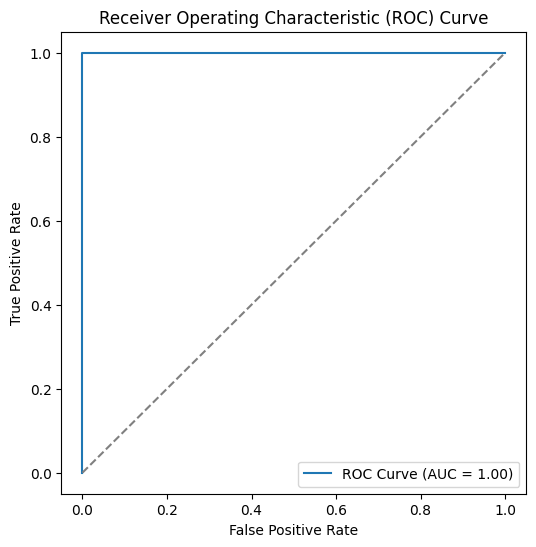

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Create a logistic regression model with L2 regularization
model = LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs')

# Train the model on the entire dataset (using train-test split)
model.fit(X_encoded, y)

# Predict on the same data
y_pred = model.predict(X_encoded)

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:\n", classification_report(y, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y, model.predict_proba(X_encoded)[:, 1])
print("\nROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X_encoded)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
